In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 0 ns


## non vectorized solution

In [9]:
def hough_acc(edge_img, rho_resolution= 1, theta_resolution = 1):
    rows, cols = edge_img.shape    
    d = np.round(np.sqrt(rows**2 + cols**2))
    thetas = np.arange(-90, 90, theta_resolution)
    rhos = np.arange(-d, d + 1, rho_resolution)
    
    #all cos, sin thetas 0 from 180 degree
    cos_thetas = np.cos(np.deg2rad(thetas))
    sin_thetas = np.sin(np.deg2rad(thetas))
    accumulator = np.zeros((len(rhos), len(thetas)))
    cnt = 0
    for row in range(rows):
        for col in range(cols):
            # if seletecd point is edge
            if edge_img[row, col] != 0:
                cnt += 1
                # check all possible thetas
                for theta_idx in range(len(thetas)):
                    # rho = (x_dist * cos(theta)) + (y_dist * sin(theta))
                    rho =int(d + (col* cos_thetas[theta_idx])+(row *sin_thetas[theta_idx]))
                    accumulator[rho, theta_idx] += 1
    return accumulator, rhos, thetas    

def find_peak(accumulator, rhos, thetas, threhsold=60):
    
    lines = []
    for y in range(accumulator.shape[0]):
        rho = rhos[y]
        for x in range(accumulator.shape[1]):
            if accumulator[y][x] > threhsold:
                theta = np.deg2rad(thetas[x])
                lines.append([rho, theta])
    
    return np.array(lines)

def draw_hough_lines(img, lines):
    res = img.copy()
    for i, line in enumerate(lines):
        rho = line[0]
        theta = line[1]
        # reverse engineer lines from rhos and thetas
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        
        # these are then scaled so that the lines go off the edges of the image
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        cv2.circle(res, (int(x0), int(y0)),2,(0,0,255),1)
        cv2.line(res, (x1, y1), (x2, y2), (0, 255, 0), 1)
        plt.imshow(res,cmap="gray")

time: 15 ms


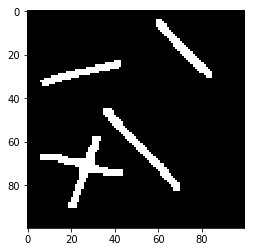

time: 2.02 s


In [10]:
img = cv2.imread("./res/simple_line2.jpg",0)
blur = cv2.GaussianBlur(img, (3, 3), 1)
canny = cv2.Canny(blur, 100, 200)
morph = cv2.morphologyEx(canny, cv2.MORPH_CLOSE, np.ones((5,5)))
plt.imshow(morph, cmap="gray")

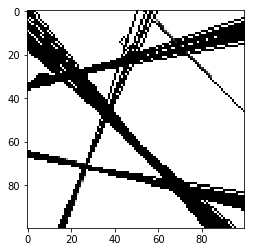

time: 1.89 s


In [11]:
acc, rhos, thetas = hough_acc(morph)
lines = find_peak(acc, rhos,thetas,threhsold=40)
draw_hough_lines(img, lines)

### hough line in opencv

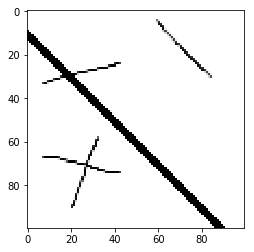

time: 203 ms


In [19]:
res = img.copy()
lines = cv2.HoughLines(morph,1,np.pi/180,1)
for rho,theta in lines[0]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv2.line(res,(x1,y1),(x2,y2),(0,0,255),2)
plt.imshow(res,cmap="gray")

In [46]:
def line_detection_vectorized(image, edge_image, num_rhos=180, num_thetas=180, t_count=220):
    res = image.copy()
    edge_height, edge_width = edge_image.shape[:2]
    edge_height_half, edge_width_half = edge_height / 2, edge_width / 2

    d = np.sqrt(np.square(edge_height) + np.square(edge_width))
    dtheta = 180 / num_thetas
    drho = (2 * d) / num_rhos

    thetas = np.arange(0, 180, step=dtheta)
    rhos = np.arange(-d, d, step=drho)

    cos_thetas = np.cos(np.deg2rad(thetas))
    sin_thetas = np.sin(np.deg2rad(thetas))

    accumulator = np.zeros((len(rhos), len(rhos)))

    edge_points = np.argwhere(edge_image != 0)
    edge_points = edge_points - np.array([[edge_height_half, edge_width_half]])
    #
    rho_values = np.matmul(edge_points, np.array([sin_thetas, cos_thetas]))

    accumulator, theta_vals, rho_vals = np.histogram2d(
      np.tile(thetas, rho_values.shape[0]),
      rho_values.ravel(),
      bins=[thetas, rhos]
    )
    accumulator = np.transpose(accumulator)
    lines = np.argwhere(accumulator > t_count)

    for line in lines:
        y, x = line
        rho = rhos[y]
        theta = thetas[x]
        a = np.cos(np.deg2rad(theta))
        b = np.sin(np.deg2rad(theta))
        x0 = (a * rho) + edge_width_half
        y0 = (b * rho) + edge_height_half
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        res = cv2.line(res, (x1, y1), (x2, y2), (0, 255, 0), 1)

    plt.imshow(res,cmap="gray")
    return accumulator, rhos, thetas

time: 15 ms


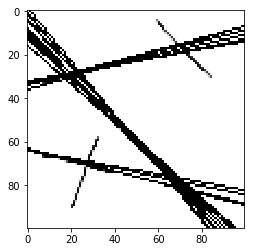

time: 203 ms


In [47]:
acc, rhos, thetas = line_detection_vectorized(img,morph,t_count=63)

In [ ]:
def hough_acc(edge_img, rho_resolution= 1, theta_resolution = 1):
    edge_height, edge_width = edge_img.shape
    edge_height_half, edge_width_half = edge_height/2, edge_width/2
    d = np.sqrt(np.square(edge_height) + np.square(edge_width))
    
    thetas = np.arange(0, 180, theta_resolution)
    rhos = np.arange(-d, d, rho_resolution)
    cos_thetas = np.cos(np.deg2rad(thetas))
    sin_thetas = np.sin(np.deg2rad(thetas))
    
    accumulator = np.zeros((len(rhos), len(thetas)))
    edge_points = np.argwhere(edge_img != 0)
    
    edge_points = edge_points - np.array([[edge_height_half, edge_width_half]])
    rho_values = np.matmul(edge_points, np.array([sin_thetas, cos_thetas]))
    
     accumulator, theta_vals, rho_vals = np.histogram2d(
          np.tile(thetas, rho_values.shape[0]),
          rho_values.ravel(),
          bins=[thetas, rhos]
      )
    


  accumulator = np.transpose(accumulator)
  lines = np.argwhere(accumulator > t_count)
  rho_idxs, theta_idxs = lines[:, 0], lines[:, 1]
  r, t = rhos[rho_idxs], thetas[theta_idxs]
    return accumulator, rhos, thetas    


In [96]:
theta_resolution = 1
rho_resolution = 1
edge_img = morph.copy()
edge_height, edge_width = edge_img.shape
edge_height_half, edge_width_half = edge_height/2, edge_width/2
d = np.sqrt(np.square(edge_height) + np.square(edge_width))

thetas = np.arange(0, 180, theta_resolution)
rhos = np.arange(-d, d, rho_resolution)
cos_thetas = np.cos(np.deg2rad(thetas))
sin_thetas = np.sin(np.deg2rad(thetas))

accumulator = np.zeros((len(rhos), len(thetas)))
edge_points = np.argwhere(edge_img != 0)


time: 0 ns


In [97]:
print(edge_points)
print(rhos.shape)
print(d)

[[ 4 59]
 [ 4 60]
 [ 4 61]
 ...
 [90 20]
 [90 21]
 [90 22]]
(283,)
141.4213562373095
time: 0 ns


In [98]:
print("edge_point[0] : {}".format(edge_points[0]))
print(edge_img[0][0])
print(edge_img[edge_points[0][0], edge_points[0][1]])
print("edge_point.shape : {}".format(edge_points.shape))
print("edge_img.shape : {}".format(edge_img.shape))

edge_point[0] : [ 4 59]
0
255
edge_point.shape : (706, 2)
edge_img.shape : (100, 100)
time: 0 ns


In [99]:
edge_points = edge_points - np.array([[edge_height_half, edge_width_half]])
print(edge_points[:3])

[[-46.   9.]
 [-46.  10.]
 [-46.  11.]]
time: 0 ns


In [102]:
rho_values = np.matmul(edge_points, np.array([sin_thetas, cos_thetas]))
print(sin_thetas.shape)
print(sin_thetas[:5])
print(cos_thetas.shape)
print(cos_thetas[:5])
print(rho_values.shape)
print(np.max(rho_values))

(180,)
[0.         0.01745241 0.0348995  0.05233596 0.06975647]
(180,)
[1.         0.9998477  0.99939083 0.99862953 0.99756405]
(706, 180)
50.60593587936429
time: 0 ns


In [103]:
print(thetas[:4])
print(rho_values.shape[0])
t = np.tile(thetas, rho_values.shape[0])
print(t)
print(t[181:])
print("706 x 180 = {}".format(t.shape))

[0 1 2 3]
706
[  0   1   2 ... 177 178 179]
[  1   2   3 ... 177 178 179]
706 x 180 = (127080,)
time: 16 ms


In [75]:
rv = rho_values.ravel()
print(rv)
print(rv.shape)

[ 9.          8.19581856  7.38914059 ... 30.05506522 29.37892302
 28.69383172]
(127080,)
time: 16 ms


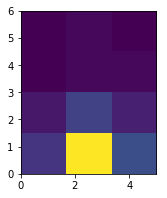

time: 157 ms


In [89]:
xedges = [0, 1, 3, 5]
yedges = [0, 2, 3, 4, 6]

x = np.random.normal(2, 1, 100)
y = np.random.normal(1, 1, 100)
H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges))
H = H.T  # Let each row list bins with common y range.


fig = plt.figure(figsize=(7, 3))
plt.imshow(H, interpolation='nearest', origin='low',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

In [90]:
accumulator, theta_vals, rho_vals = np.histogram2d(
  np.tile(thetas, rho_values.shape[0]),
  rho_values.ravel(),
  bins=[thetas, rhos]
)

time: 0 ns


In [93]:
print(accumulator.shape)
print(theta_vals.shape)
print(rho_vals.shape)

(179, 179)
(180,)
(180,)
time: 0 ns


In [119]:
edge_height, edge_width = edge_img.shape
edge_height_half, edge_width_half = edge_height/2, edge_width/2
d = np.sqrt(np.square(edge_height) + np.square(edge_width))

thetas = np.arange(0, 180, theta_resolution)
rhos = np.arange(-d, d, rho_resolution)
cos_thetas = np.cos(np.deg2rad(thetas))
sin_thetas = np.sin(np.deg2rad(thetas))

accumulator = np.zeros((len(rhos), len(thetas)))
edge_points = np.argwhere(edge_img != 0)

edge_points = edge_points - np.array([[edge_height_half, edge_width_half]])
rho_values = np.matmul(edge_points, np.array([sin_thetas, cos_thetas]))

time: 0 ns


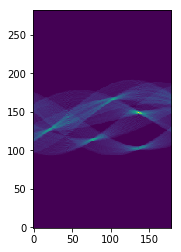

time: 188 ms


In [120]:
accumulator, theta_vals, rho_vals = np.histogram2d(
  np.tile(thetas, rho_values.shape[0]),
  rho_values.ravel(),
  bins=[thetas, rhos]
)

plt.imshow(accumulator.T, interpolation='nearest', origin='low')

In [124]:
print(theta_vals[:5])
print(rho_vals[:5])
print(accumulator.shape)

[0 1 2 3 4]
[-141.42135624 -140.42135624 -139.42135624 -138.42135624 -137.42135624]
(179, 282)
time: 0 ns


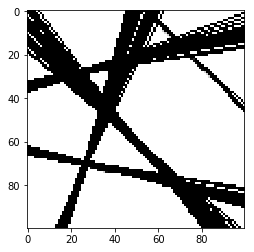

time: 219 ms


In [129]:
threshold = 37
accumulator = np.transpose(accumulator)
lines = np.argwhere(accumulator > threshold)

res = img.copy()
for line in lines:
    y, x = line
    rho = rhos[y]
    theta = thetas[x]
    a = np.cos(np.deg2rad(theta))
    b = np.sin(np.deg2rad(theta))
    x0 = (a * rho) + edge_width_half
    y0 = (b * rho) + edge_height_half
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    res = cv2.line(res, (x1, y1), (x2, y2), (0, 255, 0), 1)

plt.imshow(res,cmap="gray")

In [132]:
def hough_line(edge_img, rho_resolution= 1, theta_resolution = 1, threshold=10):
    edge_height, edge_width = edge_img.shape
    edge_height_half, edge_width_half = edge_height/2, edge_width/2
    d = np.sqrt(np.square(edge_height) + np.square(edge_width))
    
    thetas = np.arange(0, 180, theta_resolution)
    rhos = np.arange(-d, d, rho_resolution)
    cos_thetas = np.cos(np.deg2rad(thetas))
    sin_thetas = np.sin(np.deg2rad(thetas))
    
    accumulator = np.zeros((len(rhos), len(thetas)))
    edge_points = np.argwhere(edge_img != 0)
    
    edge_points = edge_points - np.array([[edge_height_half, edge_width_half]])
    rho_values = np.matmul(edge_points, np.array([sin_thetas, cos_thetas]))

    accumulator, theta_vals, rho_vals = np.histogram2d(
      np.tile(thetas, rho_values.shape[0]),
      rho_values.ravel(),
      bins=[thetas, rhos]
    )
    accumulator = np.transpose(accumulator)
    lines = np.argwhere(accumulator > threshold)

    res = img.copy()
    for line in lines:
        y, x = line
        rho = rhos[y]
        theta = thetas[x]
        a = np.cos(np.deg2rad(theta))
        b = np.sin(np.deg2rad(theta))
        x0 = (a * rho) + edge_width_half
        y0 = (b * rho) + edge_height_half
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        res = cv2.line(res, (x1, y1), (x2, y2), (0, 255, 0), 1)

    plt.imshow(res,cmap="gray")
    return accumulator, rhos, thetas

time: 0 ns


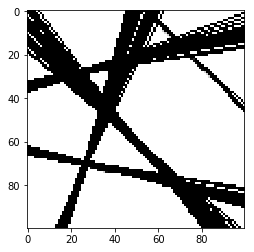

time: 218 ms


In [133]:
accumulator, rhos, thetas = hough_line(morph, 1, 1, 37)